In [2]:
"""
================================================================================
NOTEBOOK 3: DOMAIN ADAPTATION (Part 2)
================================================================================
Objective: Unsupervised Domain Adaptation using Self-Training

Strategy:
1. Train on Source 0 (labeled)
2. Predict on Target 0 Train (unlabeled)
3. Select high-confidence predictions (pseudo-labels)
4. Retrain on Source + confident Target samples
5. Evaluate on Target 0 Test

Key Concept: Transfer learning under covariate shift
================================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, f1_score,
                             precision_score, recall_score, accuracy_score)

# XGBoost
import xgboost as xgb

# Visualization
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 5)

DATA_PATH = '../data/'

print("✅ Libraries loaded")
print("🎯 Strategy: Self-Training (Pseudo-Labeling) for Domain Adaptation")

✅ Libraries loaded
🎯 Strategy: Self-Training (Pseudo-Labeling) for Domain Adaptation


In [4]:
"""
================================================================================
DATA LOADING - SOURCE 0 & TARGET 0
================================================================================
"""

print("=" * 80)
print("LOADING SOURCE 0 (Labeled)")
print("=" * 80)

# Load Source 0
X_src_train_raw = np.load(DATA_PATH + 'kaggle_source_cate_0_train.npy')
X_src_test_raw = np.load(DATA_PATH + 'kaggle_source_cate_0_test.npy')

# Extract labels and features
y_src_train_raw = X_src_train_raw[:, 0].astype(int)
X_src_train = X_src_train_raw[:, 1:]

y_src_test_raw = X_src_test_raw[:, 0].astype(int)
X_src_test = X_src_test_raw[:, 1:]

# Convert to binary (Class 2 = Fraud)
y_src_train = (y_src_train_raw == 2).astype(int)
y_src_test = (y_src_test_raw == 2).astype(int)

print(f"✅ Source 0 loaded:")
print(f"   Train: {X_src_train.shape}, Fraud: {y_src_train.sum()} ({y_src_train.mean()*100:.2f}%)")
print(f"   Test:  {X_src_test.shape}, Fraud: {y_src_test.sum()} ({y_src_test.mean()*100:.2f}%)")

print("\n" + "=" * 80)
print("LOADING TARGET 0 (Unlabeled for training)")
print("=" * 80)

# Load Target 0 - ONLY 3 FILES (train, test, test_label)
X_tgt_train_raw = np.load(DATA_PATH + 'kaggle_target_cate_0_train.npy')
X_tgt_test_raw = np.load(DATA_PATH + 'kaggle_target_cate_0_test.npy')
y_tgt_test_raw_file = np.load(DATA_PATH + 'kaggle_target_cate_0_test_label.npy').ravel()

# Extract features from train (NO LABELS in train for Target)
X_tgt_train = X_tgt_train_raw[:, 1:]  # Assume first column might be ID, skip it
print(f"   Target Train raw shape: {X_tgt_train_raw.shape}")

# For test: extract labels and features
y_tgt_test_raw = X_tgt_test_raw[:, 0].astype(int)
X_tgt_test = X_tgt_test_raw[:, 1:]

# Convert to binary (Class 2 = Fraud)
y_tgt_test = (y_tgt_test_raw == 2).astype(int)

print(f"✅ Target 0 loaded:")
print(f"   Train: {X_tgt_train.shape} (UNLABELED - no y_train available)")
print(f"   Test:  {X_tgt_test.shape}, Fraud: {y_tgt_test.sum()} ({y_tgt_test.mean()*100:.2f}%)")

# Check if Target train has labels in first column (for verification only)
if X_tgt_train_raw.shape[1] == 51:  # If 51 columns, first might be label
    y_tgt_train_check = (X_tgt_train_raw[:, 0].astype(int) == 2).astype(int)
    print(f"   (Hidden labels in train: {y_tgt_train_check.sum()} frauds - {y_tgt_train_check.mean()*100:.2f}%)")
    print(f"   💡 Domain shift: Source {y_src_train.mean()*100:.2f}% → Target {y_tgt_train_check.mean()*100:.2f}%")

# Standardization (fit on Source, apply to both)
print("\n" + "=" * 80)
print("STANDARDIZATION")
print("=" * 80)

scaler = StandardScaler()
X_src_train_scaled = scaler.fit_transform(X_src_train)
X_src_test_scaled = scaler.transform(X_src_test)
X_tgt_train_scaled = scaler.transform(X_tgt_train)
X_tgt_test_scaled = scaler.transform(X_tgt_test)

print("✅ All datasets standardized using Source statistics")

LOADING SOURCE 0 (Labeled)
✅ Source 0 loaded:
   Train: (41058, 50), Fraud: 6427 (15.65%)
   Test:  (13686, 50), Fraud: 2168 (15.84%)

LOADING TARGET 0 (Unlabeled for training)
   Target Train raw shape: (62788, 51)
✅ Target 0 loaded:
   Train: (62788, 50) (UNLABELED - no y_train available)
   Test:  (20930, 50), Fraud: 614 (2.93%)
   (Hidden labels in train: 2088 frauds - 3.33%)
   💡 Domain shift: Source 15.65% → Target 3.33%

STANDARDIZATION
✅ All datasets standardized using Source statistics


In [6]:
"""
================================================================================
BASELINE: SOURCE-ONLY MODEL (No Adaptation)
================================================================================
Train on Source 0, evaluate on Target 0 Test
"""

print("=" * 80)
print("TRAINING SOURCE-ONLY MODEL")
print("=" * 80)

# Train on Source with cost-sensitive learning (best from Part 1)
scale_pos_weight = Counter(y_src_train)[0] / Counter(y_src_train)[1]

source_only_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

source_only_model.fit(X_src_train_scaled, y_src_train)

print(f"✅ Model trained on Source (scale_pos_weight={scale_pos_weight:.2f})")

# Evaluate on Source Test
print("\n" + "=" * 80)
print("PERFORMANCE ON SOURCE TEST")
print("=" * 80)

y_pred_src = source_only_model.predict(X_src_test_scaled)
y_proba_src = source_only_model.predict_proba(X_src_test_scaled)[:, 1]

print(classification_report(y_src_test, y_pred_src, 
                          target_names=['Legitimate', 'Fraud'], 
                          digits=4))

src_recall = recall_score(y_src_test, y_pred_src)
src_f1 = f1_score(y_src_test, y_pred_src)
src_auc = roc_auc_score(y_src_test, y_proba_src)

print(f"Source Test - Recall: {src_recall:.4f}, F1: {src_f1:.4f}, AUC: {src_auc:.4f}")

# Evaluate on Target Test (WITHOUT adaptation)
print("\n" + "=" * 80)
print("PERFORMANCE ON TARGET TEST (No Adaptation)")
print("=" * 80)

y_pred_tgt_baseline = source_only_model.predict(X_tgt_test_scaled)
y_proba_tgt_baseline = source_only_model.predict_proba(X_tgt_test_scaled)[:, 1]

print(classification_report(y_tgt_test, y_pred_tgt_baseline, 
                          target_names=['Legitimate', 'Fraud'], 
                          digits=4))

tgt_recall_baseline = recall_score(y_tgt_test, y_pred_tgt_baseline)
tgt_f1_baseline = f1_score(y_tgt_test, y_pred_tgt_baseline)
tgt_auc_baseline = roc_auc_score(y_tgt_test, y_proba_tgt_baseline)

print(f"\n📊 Target Test (Baseline):")
print(f"   Recall: {tgt_recall_baseline:.4f} ⚠️ (Domain shift impact)")
print(f"   F1:     {tgt_f1_baseline:.4f}")
print(f"   AUC:    {tgt_auc_baseline:.4f}")

# Store results
results = {
    'Source-Only (Baseline)': {
        'recall': tgt_recall_baseline,
        'f1_score': tgt_f1_baseline,
        'auc_roc': tgt_auc_baseline,
        'y_pred': y_pred_tgt_baseline,
        'y_proba': y_proba_tgt_baseline
    }
}

print("\n💡 Goal: Improve Target performance using Self-Training")

TRAINING SOURCE-ONLY MODEL
✅ Model trained on Source (scale_pos_weight=5.39)

PERFORMANCE ON SOURCE TEST
              precision    recall  f1-score   support

  Legitimate     0.9976    0.9804    0.9889     11518
       Fraud     0.9045    0.9875    0.9442      2168

    accuracy                         0.9815     13686
   macro avg     0.9511    0.9840    0.9666     13686
weighted avg     0.9829    0.9815    0.9818     13686

Source Test - Recall: 0.9875, F1: 0.9442, AUC: 0.9988

PERFORMANCE ON TARGET TEST (No Adaptation)
              precision    recall  f1-score   support

  Legitimate     0.9878    0.9760    0.9819     20316
       Fraud     0.4317    0.6026    0.5031       614

    accuracy                         0.9651     20930
   macro avg     0.7098    0.7893    0.7425     20930
weighted avg     0.9715    0.9651    0.9679     20930


📊 Target Test (Baseline):
   Recall: 0.6026 ⚠️ (Domain shift impact)
   F1:     0.5031
   AUC:    0.9765

💡 Goal: Improve Target performance u

In [7]:
"""
================================================================================
SELF-TRAINING: PSEUDO-LABELING (Iteration 1)
================================================================================
Strategy:
1. Use Source-only model to predict on Target Train
2. Select high-confidence predictions (threshold = 0.9 for fraud, 0.1 for legit)
3. Add pseudo-labeled Target samples to Source Train
4. Retrain model on augmented dataset
"""

print("=" * 80)
print("STEP 1: GENERATE PSEUDO-LABELS ON TARGET TRAIN")
print("=" * 80)

# Predict on Target Train (unlabeled)
y_proba_tgt_train = source_only_model.predict_proba(X_tgt_train_scaled)[:, 1]

# Define confidence thresholds
threshold_fraud = 0.90      # High confidence for fraud (Class 1)
threshold_legit = 0.10      # High confidence for legitimate (Class 0)

# Select confident samples
confident_fraud = y_proba_tgt_train >= threshold_fraud
confident_legit = y_proba_tgt_train <= threshold_legit
confident_mask = confident_fraud | confident_legit

X_confident = X_tgt_train_scaled[confident_mask]
y_pseudo = (y_proba_tgt_train[confident_mask] >= 0.5).astype(int)

print(f"✅ Pseudo-labels generated:")
print(f"   Total Target Train: {len(X_tgt_train_scaled):,}")
print(f"   Confident samples:  {confident_mask.sum():,} ({confident_mask.sum()/len(X_tgt_train_scaled)*100:.2f}%)")
print(f"   - Confident Legit:  {confident_legit.sum():,} (proba < {threshold_legit})")
print(f"   - Confident Fraud:  {confident_fraud.sum():,} (proba > {threshold_fraud})")
print(f"\n   Pseudo-label distribution: {Counter(y_pseudo)}")

# Combine Source + Confident Target
print("\n" + "=" * 80)
print("STEP 2: AUGMENT TRAINING SET")
print("=" * 80)

X_augmented = np.vstack([X_src_train_scaled, X_confident])
y_augmented = np.concatenate([y_src_train, y_pseudo])

print(f"✅ Augmented dataset:")
print(f"   Original Source:     {len(X_src_train_scaled):,}")
print(f"   + Confident Target:  {len(X_confident):,}")
print(f"   = Total:             {len(X_augmented):,}")
print(f"\n   Augmented distribution: {Counter(y_augmented)}")

# Retrain model
print("\n" + "=" * 80)
print("STEP 3: RETRAIN ON AUGMENTED DATA")
print("=" * 80)

scale_pos_weight_aug = Counter(y_augmented)[0] / Counter(y_augmented)[1]

adapted_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight_aug,
    random_state=42,
    eval_metric='logloss'
)

adapted_model.fit(X_augmented, y_augmented)

print(f"✅ Model retrained (scale_pos_weight={scale_pos_weight_aug:.2f})")

# Evaluate on Target Test
print("\n" + "=" * 80)
print("STEP 4: EVALUATE ON TARGET TEST (After Adaptation)")
print("=" * 80)

y_pred_tgt_adapted = adapted_model.predict(X_tgt_test_scaled)
y_proba_tgt_adapted = adapted_model.predict_proba(X_tgt_test_scaled)[:, 1]

print(classification_report(y_tgt_test, y_pred_tgt_adapted, 
                          target_names=['Legitimate', 'Fraud'], 
                          digits=4))

tgt_recall_adapted = recall_score(y_tgt_test, y_pred_tgt_adapted)
tgt_f1_adapted = f1_score(y_tgt_test, y_pred_tgt_adapted)
tgt_auc_adapted = roc_auc_score(y_tgt_test, y_proba_tgt_adapted)

print(f"\n📊 Target Test (After Adaptation):")
print(f"   Recall: {tgt_recall_adapted:.4f}")
print(f"   F1:     {tgt_f1_adapted:.4f}")
print(f"   AUC:    {tgt_auc_adapted:.4f}")

# Improvement
recall_improvement = (tgt_recall_adapted - tgt_recall_baseline) * 100
f1_improvement = (tgt_f1_adapted - tgt_f1_baseline) * 100

print(f"\n📈 IMPROVEMENT:")
print(f"   Recall: {tgt_recall_baseline:.4f} → {tgt_recall_adapted:.4f} ({recall_improvement:+.2f}%)")
print(f"   F1:     {tgt_f1_baseline:.4f} → {tgt_f1_adapted:.4f} ({f1_improvement:+.2f}%)")

# Store results
results['Self-Training (Iter 1)'] = {
    'recall': tgt_recall_adapted,
    'f1_score': tgt_f1_adapted,
    'auc_roc': tgt_auc_adapted,
    'y_pred': y_pred_tgt_adapted,
    'y_proba': y_proba_tgt_adapted
}

print("\n✅ Self-Training Iteration 1 completed")

STEP 1: GENERATE PSEUDO-LABELS ON TARGET TRAIN
✅ Pseudo-labels generated:
   Total Target Train: 62,788
   Confident samples:  58,960 (93.90%)
   - Confident Legit:  58,112 (proba < 0.1)
   - Confident Fraud:  848 (proba > 0.9)

   Pseudo-label distribution: Counter({0: 58112, 1: 848})

STEP 2: AUGMENT TRAINING SET
✅ Augmented dataset:
   Original Source:     41,058
   + Confident Target:  58,960
   = Total:             100,018

   Augmented distribution: Counter({0: 92743, 1: 7275})

STEP 3: RETRAIN ON AUGMENTED DATA
✅ Model retrained (scale_pos_weight=12.75)

STEP 4: EVALUATE ON TARGET TEST (After Adaptation)
              precision    recall  f1-score   support

  Legitimate     0.9890    0.9710    0.9799     20316
       Fraud     0.4004    0.6417    0.4931       614

    accuracy                         0.9613     20930
   macro avg     0.6947    0.8063    0.7365     20930
weighted avg     0.9717    0.9613    0.9656     20930


📊 Target Test (After Adaptation):
   Recall: 0.6417
 

In [8]:
"""
================================================================================
SELF-TRAINING: ITERATION 2 (Refinement)
================================================================================
Use the adapted model to generate better pseudo-labels
"""

print("=" * 80)
print("ITERATION 2: RE-GENERATE PSEUDO-LABELS")
print("=" * 80)

# Use adapted model (instead of source-only) for better predictions
y_proba_tgt_train_v2 = adapted_model.predict_proba(X_tgt_train_scaled)[:, 1]

# Same thresholds
confident_fraud_v2 = y_proba_tgt_train_v2 >= threshold_fraud
confident_legit_v2 = y_proba_tgt_train_v2 <= threshold_legit
confident_mask_v2 = confident_fraud_v2 | confident_legit_v2

X_confident_v2 = X_tgt_train_scaled[confident_mask_v2]
y_pseudo_v2 = (y_proba_tgt_train_v2[confident_mask_v2] >= 0.5).astype(int)

print(f"✅ Pseudo-labels v2 generated:")
print(f"   Confident samples:  {confident_mask_v2.sum():,} ({confident_mask_v2.sum()/len(X_tgt_train_scaled)*100:.2f}%)")
print(f"   - Confident Legit:  {confident_legit_v2.sum():,}")
print(f"   - Confident Fraud:  {confident_fraud_v2.sum():,}")
print(f"   Pseudo-label distribution: {Counter(y_pseudo_v2)}")

# Augment again
X_augmented_v2 = np.vstack([X_src_train_scaled, X_confident_v2])
y_augmented_v2 = np.concatenate([y_src_train, y_pseudo_v2])

scale_pos_weight_v2 = Counter(y_augmented_v2)[0] / Counter(y_augmented_v2)[1]

# Retrain
adapted_model_v2 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight_v2,
    random_state=42,
    eval_metric='logloss'
)

adapted_model_v2.fit(X_augmented_v2, y_augmented_v2)

print(f"✅ Model retrained (Iteration 2)")

# Evaluate
y_pred_tgt_v2 = adapted_model_v2.predict(X_tgt_test_scaled)
y_proba_tgt_v2 = adapted_model_v2.predict_proba(X_tgt_test_scaled)[:, 1]

print("\n" + "=" * 80)
print("EVALUATION: ITERATION 2")
print("=" * 80)

print(classification_report(y_tgt_test, y_pred_tgt_v2, 
                          target_names=['Legitimate', 'Fraud'], 
                          digits=4))

tgt_recall_v2 = recall_score(y_tgt_test, y_pred_tgt_v2)
tgt_f1_v2 = f1_score(y_tgt_test, y_pred_tgt_v2)
tgt_auc_v2 = roc_auc_score(y_tgt_test, y_proba_tgt_v2)

print(f"\n📊 Target Test (Iteration 2):")
print(f"   Recall: {tgt_recall_v2:.4f}")
print(f"   F1:     {tgt_f1_v2:.4f}")
print(f"   AUC:    {tgt_auc_v2:.4f}")

# Compare all iterations
print("\n" + "=" * 80)
print("COMPARISON: ALL ITERATIONS")
print("=" * 80)

comparison = pd.DataFrame({
    'Method': ['Source-Only', 'Self-Train Iter1', 'Self-Train Iter2'],
    'Recall': [tgt_recall_baseline, tgt_recall_adapted, tgt_recall_v2],
    'F1-Score': [tgt_f1_baseline, tgt_f1_adapted, tgt_f1_v2],
    'AUC-ROC': [tgt_auc_baseline, tgt_auc_adapted, tgt_auc_v2]
})

print(comparison.to_string(index=False))

# Store
results['Self-Training (Iter 2)'] = {
    'recall': tgt_recall_v2,
    'f1_score': tgt_f1_v2,
    'auc_roc': tgt_auc_v2,
    'y_pred': y_pred_tgt_v2,
    'y_proba': y_proba_tgt_v2
}

print("\n✅ Iteration 2 completed")

ITERATION 2: RE-GENERATE PSEUDO-LABELS
✅ Pseudo-labels v2 generated:
   Confident samples:  59,706 (95.09%)
   - Confident Legit:  58,369
   - Confident Fraud:  1,337
   Pseudo-label distribution: Counter({0: 58369, 1: 1337})
✅ Model retrained (Iteration 2)

EVALUATION: ITERATION 2
              precision    recall  f1-score   support

  Legitimate     0.9898    0.9701    0.9798     20316
       Fraud     0.4031    0.6678    0.5028       614

    accuracy                         0.9613     20930
   macro avg     0.6965    0.8189    0.7413     20930
weighted avg     0.9725    0.9613    0.9658     20930


📊 Target Test (Iteration 2):
   Recall: 0.6678
   F1:     0.5028
   AUC:    0.9763

COMPARISON: ALL ITERATIONS
          Method   Recall  F1-Score  AUC-ROC
     Source-Only 0.602606  0.503059 0.976490
Self-Train Iter1 0.641694  0.493116 0.975905
Self-Train Iter2 0.667752  0.502759 0.976340

✅ Iteration 2 completed


FINAL COMPARISON TABLE
                Method Recall F1-Score AUC-ROC Frauds Detected
Source-Only (Baseline) 0.6026   0.5031  0.9765         370/614
  Self-Training Iter 1 0.6417   0.4931  0.9759         393/614
  Self-Training Iter 2 0.6678   0.5028  0.9763         410/614


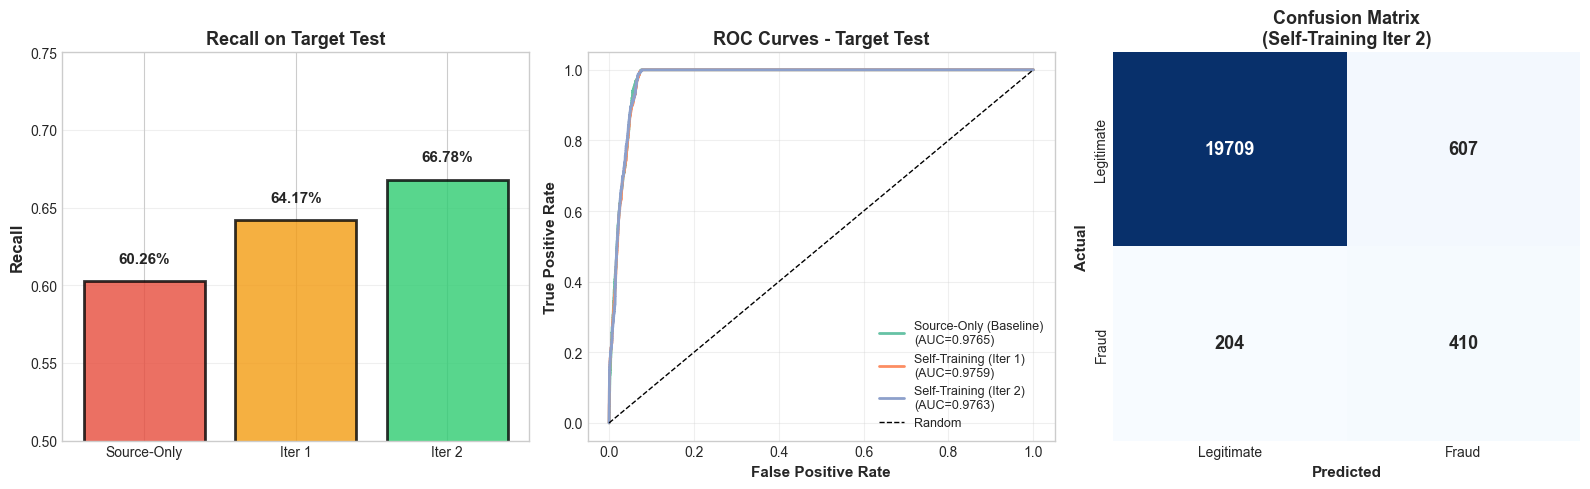


✅ Visualization saved to '../results/part2_domain_adaptation.png'


In [9]:
"""
================================================================================
FINAL RESULTS & VISUALIZATION
================================================================================
"""

print("=" * 80)
print("FINAL COMPARISON TABLE")
print("=" * 80)

final_comparison = pd.DataFrame({
    'Method': ['Source-Only (Baseline)', 'Self-Training Iter 1', 'Self-Training Iter 2'],
    'Recall': [f"{tgt_recall_baseline:.4f}", f"{tgt_recall_adapted:.4f}", f"{tgt_recall_v2:.4f}"],
    'F1-Score': [f"{tgt_f1_baseline:.4f}", f"{tgt_f1_adapted:.4f}", f"{tgt_f1_v2:.4f}"],
    'AUC-ROC': [f"{tgt_auc_baseline:.4f}", f"{tgt_auc_adapted:.4f}", f"{tgt_auc_v2:.4f}"],
    'Frauds Detected': [
        f"{int(tgt_recall_baseline * y_tgt_test.sum())}/{y_tgt_test.sum()}",
        f"{int(tgt_recall_adapted * y_tgt_test.sum())}/{y_tgt_test.sum()}",
        f"{int(tgt_recall_v2 * y_tgt_test.sum())}/{y_tgt_test.sum()}"
    ]
})

print(final_comparison.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Bar plot - Recall comparison
ax1 = axes[0]
methods = ['Source-Only', 'Iter 1', 'Iter 2']
recalls = [tgt_recall_baseline, tgt_recall_adapted, tgt_recall_v2]
colors = ['#e74c3c', '#f39c12', '#2ecc71']

bars = ax1.bar(methods, recalls, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Recall', fontweight='bold', fontsize=12)
ax1.set_title('Recall on Target Test', fontweight='bold', fontsize=13)
ax1.set_ylim([0.5, 0.75])
ax1.grid(axis='y', alpha=0.3)

# Add values on bars
for bar, recall in zip(bars, recalls):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{recall:.2%}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. ROC Curves
ax2 = axes[1]
for method, res in results.items():
    fpr, tpr, _ = roc_curve(y_tgt_test, res['y_proba'])
    ax2.plot(fpr, tpr, label=f"{method}\n(AUC={res['auc_roc']:.4f})", linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax2.set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
ax2.set_title('ROC Curves - Target Test', fontweight='bold', fontsize=13)
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(alpha=0.3)

# 3. Confusion Matrix - Best model (Iter 2)
ax3 = axes[2]
cm_best = confusion_matrix(y_tgt_test, y_pred_tgt_v2)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'],
            ax=ax3, cbar=False, annot_kws={'size': 13, 'weight': 'bold'})

ax3.set_title('Confusion Matrix\n(Self-Training Iter 2)', fontweight='bold', fontsize=13)
ax3.set_ylabel('Actual', fontweight='bold', fontsize=11)
ax3.set_xlabel('Predicted', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../results/part2_domain_adaptation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved to '../results/part2_domain_adaptation.png'")